In [1]:
#Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os as os
from scipy import constants
from scipy import stats
from copy import deepcopy
from numpy.lib import scimath
from sklearn.linear_model import LinearRegression #regresión lineal
import findiff as ff #derivadas
import bottleneck as bn #media movil
from pathlib import Path, PurePath #manejo de rutas y archivos

idioma = 'español'
#idioma = 'ingles'

#Graficación

if idioma == 'español':
    #plt.prop_cycle(color=['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97'])
    #axes.prop_cycle : cycler('color', ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9e9e9e'])
    #Latex y coma como separador decimal
    plt.rcParams['text.usetex'] = True #latex
    #plt.rc('text', usetex=False)
    plt.rcParams['axes.formatter.use_locale'] = True #formato de eje para la coma
    #se incluye paquete matematico útil, se corrige el error con el espacio y el espacio entre los números
    plt.rc('text.latex', preamble=r'\usepackage{amsmath} \DeclareUnicodeCharacter{202F}{\,} \usepackage{ziffer} \usepackage{siunitx} \sisetup{output-decimal-marker = {,}, separate-uncertainty = true}') 
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
    })
    import locale #líbreria para el formato
    locale.setlocale(locale.LC_ALL, "es_CR.utf8")

if idioma == 'ingles' :
    plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{siunitx}')
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
    })

In [2]:
def CargarDatosSonda(file_dir, filtro_I): 
    """
    Función para cargar datos de la sonda
    Entrada 
    file_dir: nombre del directorio que contiene archivos
    filtro_I: corriente a filtrar
    """
    #Se importa los nombres de archivos del directorio
    archivos_barrido = os.listdir(file_dir)
    archivos_barrido.sort()
    datos_IV = []
    datos_IV_total = []
    for iArchivo in archivos_barrido:    
        ruta_archivo = PurePath(Path(file_dir), Path(iArchivo))
        #print(ruta_archivo)
        #Se lee el archivo y se transforma a numpy array
        datos = np.array(pd.read_csv(ruta_archivo))
        nFilas, nColumnas = datos.shape
        #VI = np.ndarray((nFilas, nColumnas), dtype=np.float64)
        # Se identifican los índices que no tienen la corriente deseada
        indice_a_remover = np.where(np.absolute(datos[:][1]) < filtro_I)
        # Se remueven los índices que no tienen la corriente deseada
        datos_IV = np.delete(datos, indice_a_remover,0).tolist()
        # Se utiliza append para almacenar en la lista
        datos_IV_total.append(datos_IV[:])
        # Se convierte cada lista dentro de la lista a numpy array
        datos_IV_total_1=np.array([np.array(xi) for xi in datos_IV_total], dtype=object)
        
    return datos_IV_total_1

In [3]:
def graficador_IV(datos_IV, a):
    nFilas = datos_IV[a].shape[0]
    I_plot = []
    V_plot = []
    for n_cont in range(nFilas):
        I_plot.append(datos_IV[a][n_cont][1])
        V_plot.append(datos_IV[a][n_cont][0])
    I = np.array(I_plot)
    V = np.array(V_plot)
    I_movil = bn.move_mean(I, window=2, min_count=2) #bottleneck
    
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(111)
    ax.plot(V,I_movil,'o', linewidth=10, color = '#00B945' )
    ax.set_ylabel(r'$I$ $\left( \si{\ampere} \right)$', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.set_xlabel(r'$V_{f}$ $\left( \si{\volt} \right)$',  
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    
    ax.tick_params(axis='both', labelsize=14, width=1.5)
    ax.yaxis.get_offset_text().set_fontsize(14) #tamaño de letra del x10
    
    plt.setp(ax.spines.values(), linewidth=1.5)
    ax.set_aspect(1 / ax.get_data_ratio())
    
    plt.savefig('IvsV_exp.png', dpi=300, bbox_inches='tight') 
    
    plt.show()

In [4]:
#1.Corriente de saturación iónica
def CorrienteSi(datos_IV, a):
    #Se obtienen los valores de I y V
    nFilas = datos_IV[a].shape[0]
    I_plot = []
    V_plot = []
    for n_cont in range(nFilas):
        I_plot.append(datos_IV[a][n_cont][1])
        V_plot.append(datos_IV[a][n_cont][0])
    I = np.array(I_plot)
    V = np.array(V_plot)
    I_movil = bn.move_mean(I, window=2, min_count=2) #bottleneck
    
    #Se filtran los datos
    indices_a_remover = np.where((V >= -1)) #Revisar en la curva el intervalo para el ajuste lineal
    I_ionica = np.delete(I, indices_a_remover)
    V_ionica = np.delete(V, indices_a_remover)
    
    #Regresión lineal - corriente de saturación iónica
    reg1 = LinearRegression() #función
    reg1.fit(V_ionica.reshape(-1,1), I_ionica) #ajusta los datos
    I_pred_ionica = reg1.predict(V_ionica.reshape(-1,1)) 
    I_saturacion_ionica = reg1.intercept_ # intercepto con el eje y
    cd = reg1.score(V_ionica.reshape(-1,1), I_ionica)#coeficiente de determinación
    
    #Gráfico
    #plt.plot(V,I, 'o')
    #plt.plot(V_ionica,I_pred_ionica)
    #plt.show()
    #print('corriente iónica de saturación:',I_saturacion_ionica,'A')
    #print('coeficiente de determinación',cd)
    return I_saturacion_ionica, cd
#I_sat_ion = CorrienteSi(datos1,3)
#I_sat_ion1, r2_I_sat_ion1 = CorrienteSi(datos1,4)

In [5]:
#2.Potencial del plasma - corriente de saturación electrónica - potencial flotante
def CorrienteSe(datos_IV, a, I_saturacion_ionica):
    
    #Se obtienen los valores de I y V
    nFilas = datos_IV[a].shape[0]
    I_plot = []
    V_plot = []
    
    for n_cont in range(nFilas):
        I_plot.append(datos_IV[a][n_cont][1])
        V_plot.append(datos_IV[a][n_cont][0])
    
    I = np.array(I_plot)
    V = np.array(V_plot)
    I_movil = bn.move_mean(I, window=2, min_count=2) #bottleneck
    
    # Se filtran los datos de I y V con V >= 0
    indices_a_remover = np.where(V < 0) #se reconocen los índices donde V<0
    I_electronica = np.delete(I, indices_a_remover) - (I_saturacion_ionica)
    I_electronica_movil = bn.move_mean(I_electronica, window=1, min_count=1) #bottleneck
    V_electronica = np.delete(V, indices_a_remover)
    
    # Potencial flotante I approx 0
    I_flotante = 0.000
    indices_a_remover_VF = np.where( (np.isclose(I_electronica, I_flotante, rtol=.01, atol=.01) == False ) )  
    I_f = np.delete(I_electronica, indices_a_remover_VF)
    V_f = np.delete(V_electronica, indices_a_remover_VF)
    indice_V = np.where(I_f == np.min(I_f))[0]
    V_F = V_f[indice_V]
    
    #derivada https://github.com/maroba/findiff
    dV = V_electronica[1] - V_electronica[0] #definir el diferencial
    d_dV = ff.FinDiff(0, dV) #definir el operador y su orden
    dI_dV = d_dV(I_electronica_movil)
    
    #Segunda derivada
    d2_dV2 = ff.FinDiff(0, dV, 2)
    d2I_dV2 = d2_dV2(I_electronica_movil)

    
    #Selección de la corriente máxima y del voltaje máximo
    #El valor mayor de la derivada define el punto (potencial flotante, corriente de saturación electrónica)
    indices_a_remover_1 = np.where(dI_dV != np.max(dI_dV)) 
    I_max = np.delete(I_electronica, indices_a_remover_1)
    V_max = np.delete(V_electronica, indices_a_remover_1)
    
    
    #El valor donde de la segunda derivada se hace cero define el punto (potencial flotante, corriente de saturación electrónica)
    #indices_a_remover_2 = np.where(d2I_dV2 != d2I_dV2[13] ) 
    #I_max = np.delete(I_electronica, indices_a_remover_2)
    #V_max = np.delete(V_electronica, indices_a_remover_2)
    
    
    #print('Potencial flotante:', float(V_F), 'V')
    #print('Corriente de saturación electrónica:', I_max, 'A')
    #print('Potencial del plasma:', V_max, 'V')

    return V_max[0], I_max[0], V_F[0]

#V_plasma1, I_sat_elect1, V_flotante1 = CorrienteSe(datos1, 4, I_sat_ion1)

In [6]:
#3.Temperatura electrónica
def TemperaturaSonda(posicion, datos_IV, a, V_flot, inicial, final, I_sat_ionica): #b se ajusta para mejor r^2
    me = scipy.constants.physical_constants['electron mass'][0] #Masa del electrón
    mi = scipy.constants.physical_constants['proton mass'][0]; #La carga elemental
    #Se obtienen los valores de I y V
    nFilas = datos_IV[a].shape[0]
    I_plot = []
    V_plot = []
    for n_cont in range(nFilas):
        I_plot.append(datos_IV[a][n_cont][1])
        V_plot.append(datos_IV[a][n_cont][0])
    I = np.array(I_plot)
    V = np.array(V_plot)
    I_movil = bn.move_mean(I, window=2, min_count=2) #bottleneck
    
    # Se filtran los datos de I y V en la región adecuada a linealizarse
    indices_a_remover = np.where((I < 0) | (V < inicial) | (V > final) | (I == 0) ) 
    #indices_a_remover = np.where((I < 0) | (V > 25) | (I == 0) )
    I_T = np.log(np.delete(I, indices_a_remover))
    V_T = np.delete(V, indices_a_remover)
    #I_T = np.log(np.delete(I_movil, indices_a_remover))
    #print(I_T)
    
    #regresión lineal - Temperatura
    reg = LinearRegression() #función
    reg.fit(V_T.reshape(-1,1), I_T) #ajusta los datos
    I_pred = reg.predict(V_T.reshape(-1,1))
    cd_temp = reg.score(V_T.reshape(-1,1), I_T) #coeficiente de determinación
    
    #Se plotean los resultados del ajuste de temperatura
    #plt.plot(V_T,I_T,'o');
    #plt.plot(V_T, I_pred, color = 'blue')
    #plt.ylabel('log(I)');
    #plt.xlabel('Voltaje V (V)');
    #plt.title('log(I)-V')
    #plt.show()
    
    
    #print(reg.intercept_) # intercepto con el eje y
    #print(float(reg.coef_)) #pendiente
    m = float(reg.coef_) #cálculo de la temperatura
    T_electronica = 1/m
    #print(m)
    #print('Temperatura electrónica:',float(T_electronica),'eV')
    #print('coeficiente de determinación:', cd_temp) #coeficiente de determinación
    
    #Corriente de saturación electrónica corregida
    V_plasma_v1, __, ___ = CorrienteSe(datos_IV, a, I_sat_ionica)
    V_plasma_v2 = V_flot - T_electronica*np.log(0.61*np.sqrt(2*np.pi*me/mi))
    
    if posicion == 0.2632 or posicion == 0.2795 or posicion == 0.2703 :
        I_sat_e_nueva = np.exp(reg.predict(V_plasma_v1.reshape(-1,1)))
    else:
        I_sat_e_nueva = np.exp(reg.predict(V_plasma_v2.reshape(-1,1)))
    #print(V_plasma_prom)
    
    return T_electronica, cd_temp, I_sat_e_nueva
#T_e1, r2_T_electronica1 = TemperaturaSonda(datos1, 4, V_plasma1, V_flotante1)

In [7]:
def DensidadElectronica(I_elect_sat, posicion, T_electronica):
    #constantes
    me = scipy.constants.physical_constants['electron mass'][0] #Masa del electrón
    ec = scipy.constants.physical_constants['elementary charge'][0]; #La carga elemental
    R_p = 0.5e-03
    
    #Corrección corriente de saturación electrónica - Bhuvar 2019
    #Extraer campo magnético
    %run -i ./B+r+z/FuncionesCampoMagnetico.py
    r_BS, z_BS, B_x,B_y,B_z = np.loadtxt('./B+r+z/r+z+B_mag_componentes.txt', 
                            usecols=(0, 1, 2, 3, 4), unpack=True)
    s2DB = campo_magnetico_mapa(r_BS, z_BS)
    B_xint, B_yint, B_zint = input_campo(s2DB, B_x, B_y, B_z)
    B_neto = np.sqrt( np.power(B_xint,2) + np.power(B_yint,2) + np.power(B_zint,2) )
    factor_B = 1.009
    #B radial en z =0
    B_calculo = B_neto[10:-20,82]
    r_B = np.linspace(0.1957178997475323, 0.310000, 267)
    _, indice = find_nearest(r_B,posicion)
    #print(B_calculo[indice])
    
    #Calcular radio de larmor
    R_L_num = np.sqrt(2*me*T_electronica*ec/np.pi)
    R_L_den = ec*B_calculo[indice]
    R_L = np.divide(R_L_num, R_L_den)
    
    #Factor de corrección
    razon_radios = R_p/R_L
    beta_den = 1 + (np.pi/8 * razon_radios)
    beta = 1/beta_den
    #print(beta)
    
    #Área de la sonda corrección - 063518_1_online
    L = 3.3e-03 
    theta = np.arctan2(B_zint[10:-20,82], B_xint[10:-20,82])
    #print(np.degrees(theta))
    A_p = 2*np.pi*R_p*L + np.pi*R_p**2
    A_p_per = 2*np.pi*R_p*L*np.sin(theta[indice]) + np.pi*R_p**2*np.cos(theta[indice])    
    A_ef_1 = A_p_per*(1 - (np.exp(-1*np.power(razon_radios,2)/2)))
    A_ef_2 = A_p*np.exp(-1*np.power(razon_radios,2)/2)
    A_ef = A_ef_1 + A_ef_2
    #print((A_p-A_ef)/(A_ef)*100)
    
    #Cálculo de la densidad
    v_th = np.sqrt(8*ec*T_electronica/(np.pi*me))
    ne = (float(4*I_elect_sat))/(ec*A_ef*v_th*beta)
    #print('Densidad electrónica:', "{:.6e}".format(float(ne)), 'm^{-3}')
    return ne
#n_e = DensidadElectronica(I_sat_elect1, T_e1)

## Datos para reportar en la tesis
Se utilizará las medidas realizadas a $r = 0.2703 \, \text{m}$ etiquetada como la descarga 3.

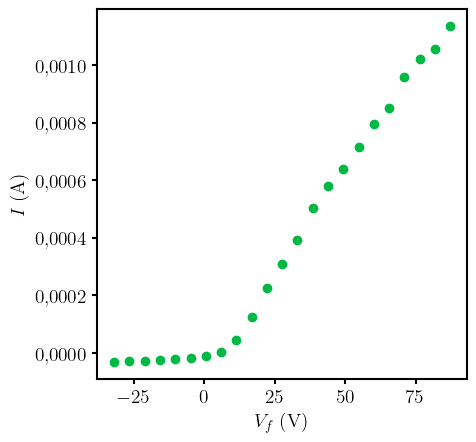

0.0004611521581668237
Corriente iónica de saturación: -1.2152158166823665e-05 A
Coeficiente de determinación I sat ion: 0.9597570458677132
Potencial flotante: 0.618486 V
Corriente de saturación electrónica: [0.00012907] A
Potencial del plasma: 33.118494 V
Temperatura electrónica: 4.2989427727420155 eV
Coeficiente de determinación T_e: 0.9601255540787386
Densidad electrónica: 5.841185e+14 m^{-3}


In [8]:
datos1 = CargarDatosSonda('0,2703', 0.00001)
a1 = 3
inicial1 = 0
final1 = 20
graficador_IV(datos1,a1)
I_sat_ion1, r2_I_sat_ion1 = CorrienteSi(datos1, a1)
V_plasma1, I_sat_elect1, V_flotante1 = CorrienteSe(datos1, a1, I_sat_ion1)
T_e1, r2_T_electronica1, I_sat_e_new1 = TemperaturaSonda(0.3100, datos1, a1, V_flotante1, inicial1, final1, I_sat_ion1)
n_e1 = DensidadElectronica(I_sat_e_new1,0.3100, T_e1)
print(I_sat_elect1)
#datos2 = CargarDatosSonda('0,3100', 0.00001)
#a2=2
#inicial2 = 10
#final2 = 20
#graficador_IV(datos2,a2)
#I_sat_ion2, r2_I_sat_ion2 = CorrienteSi(datos2, a2)
#V_plasma2, I_sat_elect2, V_flotante2 = CorrienteSe(datos2, a2, I_sat_ion2)
#T_e2, r2_T_electronica2, I_sat_e_new2 = TemperaturaSonda(datos2, a2, V_flotante2, inicial2, final2)
#n_e2 = DensidadElectronica(I_sat_e_new2, 0.2632, T_e2)


print('Corriente iónica de saturación:',I_sat_ion1,'A')
print('Coeficiente de determinación I sat ion:',r2_I_sat_ion1)
print('Potencial flotante:', V_flotante1, 'V')
print('Corriente de saturación electrónica:', I_sat_e_new1, 'A')
print('Potencial del plasma:', V_plasma1, 'V')
print('Temperatura electrónica:',T_e1,'eV')
print('Coeficiente de determinación T_e:', r2_T_electronica1) 
print('Densidad electrónica:', "{:.6e}".format(n_e1), 'm^{-3}')

#print('Corriente iónica de saturación:',I_sat_ion2,'A')
#print('Coeficiente de determinación I sat ion:',r2_I_sat_ion2)
#print('Potencial flotante:', V_flotante2, 'V')
#print('Corriente de saturación electrónica:', I_sat_e_new2, 'A')
#print('Potencial del plasma:', V_plasma2, 'V')
#print('Temperatura electrónica:',T_e2,'eV')
#print('Coeficiente de determinación T_e:', r2_T_electronica2) 
#print('Densidad electrónica:', "{:.6e}".format(n_e2), 'm^{-3}')

Gráfica de perfiles de densidad y temperaturas

In [9]:
#Datos de densidad y temperatura para cada descarga
def Te_ne(Descarga, filtro, inicial, final, posicion):
    datosIV = CargarDatosSonda(Descarga, filtro)
    T_e_descarga = []
    n_e_descarga = []
    for cont in range(len(datosIV)):
        #graficador_IV(datosIV, cont)
        I_sat_ion, _ = CorrienteSi(datosIV,cont)
        V_plasma, I_sat_elect, V_flotante = CorrienteSe(datosIV, cont, I_sat_ion)
        T_e, r2_T_electronica, I_sat_elect_n = TemperaturaSonda(
            posicion, datosIV, cont, V_flotante, inicial, final, I_sat_ion)
        T_e_descarga.append(T_e)
        n_e =DensidadElectronica(I_sat_elect_n, posicion, T_e)
        n_e_descarga.append(n_e)
        #print('Corriente iónica de saturación:',I_sat_ion,'A')
        #print('Coeficiente de determinación I sat ion:',r2_I_sat_ion)
        #print('Potencial flotante:', V_flotante, 'V')
        #print('Corriente de saturación electrónica:', I_sat_elect, 'A')
        #print('Potencial del plasma:', V_plasma, 'V')
        #print('Temperatura electrónica:',T_e,'eV')
        #print('Coeficiente de determinación T_e:', r2_T_electronica) 
        #print('Densidad electrónica:', "{:.6e}".format(n_e*10), 'm^{-3}')
    #print('\n')
    T_e_total = np.array(T_e_descarga)
    n_e_total = np.array(n_e_descarga)
    #print(T_e_total, n_e_total)
    return T_e_total, n_e_total

In [ ]:
T_e_41, n_e_41 = Te_ne('0,2632',0.00001, 10, 30)
print(np.mean([n_e_41[0], n_e_41[5], n_e_41[10]]))
print(np.mean([n_e_41[1], n_e_41[6], n_e_41[11]]))
print(np.mean([n_e_41[2], n_e_41[7], n_e_41[12]]))
print(np.mean([n_e_41[3], n_e_41[8], n_e_41[13]]))
print(np.mean([n_e_41[4], n_e_41[9], n_e_41[14]]))

In [ ]:
#Ajuste de cada medición con el r^2 mejor para el ajuste de la temperatura
r_exp = np.array([0,2477, 0.2548, 0.2632, 0.2703, 0.2795, 0.2891, 0.2985, 0.3100]) #original
#T_e_11, n_e_11 = Te_ne('0,2477',0.00001, 10, 20, 0.2477)
#T_e_21, n_e_21 = Te_ne('0,2548',0.00001, 15, 30, 0.2548)
#T_e_31, n_e_31 = Te_ne('0,2632',0.00001, 10, 30, 0.2632)
#T_e_41, n_e_41 = Te_ne('0,2703',0.00001, 10, 30, 0.2703)
#T_e_51, n_e_51 = Te_ne('0,2795',0.00001, 0, 30, 0.2795)
T_e_61, n_e_61 = Te_ne('0,2891',0.00001, 0, 20, 0.2891)
#T_e_7, n_e_7 = Te_ne('0,2985',0.00001, 0, 20, 0.2985)
#T_e_8, n_e_8 = Te_ne('0,3100',0.00001, 0, 15, 0.3100)

print(n_e_61)
#print(T_e_5[4], T_e_5[9], T_e_5[14] )
r_1 = 0.2477*np.ones(T_e_1.shape)
r_2 = 0.2548*np.ones(T_e_2.shape)
r_3 = 0.2632*np.ones(T_e_3.shape)
r_4 = 0.2703*np.ones(T_e_4.shape)
r_5 = 0.2795*np.ones(T_e_5.shape)
r_6 = 0.2891*np.ones(T_e_6.shape)
r_7 = 0.2985*np.ones(T_e_7.shape)
r_8 = 0.3100*np.ones(T_e_8.shape)
#plt.plot(r_1, T_e_1, 'o')
#plt.plot(r_2, T_e_2, 'o')
#plt.plot(r_3, T_e_3, 'o')
#plt.plot(r_4, T_e_4, 'o')
#plt.plot(r_5, T_e_5, 'o')
#plt.plot(r_6, T_e_6, 'o')
#plt.plot(r_7, T_e_7, 'o')
#plt.plot(r_8, T_e_8, 'o')
#plt.xlabel('r (m)')
#plt.ylabel('Te (eV)')

#plt.plot(r_1, n_e_1*10, 'o')
#plt.plot(r_2, n_e_2*1, 'o')
#plt.plot(r_3, n_e_3*10, 'o')
#plt.plot(r_4, n_e_4*1, 'o')
#plt.plot(r_5, n_e_5*1, 'o')
#plt.plot(r_6, n_e_6*0.1, 'o')
#plt.plot(r_7, n_e_7*1, 'o')
#plt.plot(r_8, n_e_8*1, 'o')
#plt.xlabel('r (m)')
#plt.ylabel('ne (m-3)')

#print('{:.5E}'.format(n_e_4[4]*1), '{:.5E}'.format(n_e_4[9]*1), '{:.5E}'.format(n_e_4[14]*1))
#print(n_e_3)

In [10]:
#Ajuste de temperatura y densidad 1
#Se obtienen los datos de temperatura y densidad en cada posición radial
T_e_1, n_e_x = Te_ne('0,2477',0.00001, 10, 20, 0.2477)
T_e_2, n_e_x = Te_ne('0,2548',0.00001, 15, 30, 0.2548)
T_e_3, n_e_x = Te_ne('0,2632',0.00001, 10, 30, 0.2632)
T_e_4, n_e_x = Te_ne('0,2703',0.00001, 10, 30, 0.2703)
T_e_5, n_e_x = Te_ne('0,2795',0.00001, 0, 30, 0.2795)
T_e_6, n_e_6 = Te_ne('0,2891',0.00001, 0, 20, 0.2891)
T_e_7, n_e_7 = Te_ne('0,2985',0.00001, 0, 20, 0.2985)
T_e_8, n_e_x = Te_ne('0,3100',0.00001, 0, 15, 0.3100)


In [11]:
#Ajuste de temperatura y densidad 1
T_e_x, n_e_1 = Te_ne('0,2477',0.00001, 0, 10, 0.2477)
T_e_x, n_e_2 = Te_ne('0,2548',0.00001, 10, 20, 0.2548)
T_e_x, n_e_3 = Te_ne('0,2632',0.00001, 10, 20, 0.2632)
T_e_x, n_e_4 = Te_ne('0,2703',0.00001, 10, 20, 0.2703)
T_e_x, n_e_5 = Te_ne('0,2795',0.00001, 0, 45, 0.2795)
T_e_x, n_e_8 = Te_ne('0,3100',0.00001, 10, 20, 0.3100)

In [12]:
#Ajuste 2 de temperatura y densidad
#Se obtienen los datos de temperatura y densidad en cada posición radial
T_e_10, n_e_x = Te_ne('0,2477',0.00001, 10, 20, 0.2477)
T_e_20, n_e_x = Te_ne('0,2548',0.00001, 15, 30, 0.2548)
T_e_30, n_e_x = Te_ne('0,2632',0.00001, 10, 30, 0.2632)
T_e_40, n_e_x = Te_ne('0,2703',0.00001, 10, 30, 0.2703)
T_e_50, n_e_x = Te_ne('0,2795',0.00001, 0, 30, 0.2795)
T_e_60, n_e_60 = Te_ne('0,2891',0.00001, 0, 20, 0.2891)
T_e_70, n_e_70 = Te_ne('0,2985',0.00001, 0, 20, 0.2985)
T_e_80, n_e_x = Te_ne('0,3100',0.00001, 0, 15, 0.3100)

In [13]:
T_e_x, n_e_10 = Te_ne('0,2477',0.00001, 0, 10, 0.2477)
T_e_x, n_e_20 = Te_ne('0,2548',0.00001, 10, 20, 0.2548)
T_e_x, n_e_30 = Te_ne('0,2632',0.00001, 10, 20, 0.2632)
T_e_x, n_e_40 = Te_ne('0,2703',0.00001, 10, 20, 0.2703)
T_e_x, n_e_50 = Te_ne('0,2795',0.00001, 0, 45, 0.2795)
T_e_x, n_e_80 = Te_ne('0,3100',0.00001, 10, 20, 0.3100)

In [15]:
#Valores en un barrido determinado (tercer y cuarto)
T_e_20_B = np.array([T_e_20[3], T_e_20[8], T_e_20[13]])
T_e_30_B = np.array([T_e_30[3], T_e_30[8], T_e_30[13]])
T_e_40_B = np.array([T_e_40[3], T_e_40[8], T_e_40[13]])
T_e_50_B = np.array([T_e_50[1], T_e_50[6], T_e_50[11]])
T_e_60_B = np.array([T_e_60[3], T_e_60[8], T_e_60[13]])
T_e_70_B = np.array([T_e_70[3], T_e_70[8], T_e_70[13]])
T_e_80_B = np.array([T_e_80[3], T_e_80[7], T_e_80[12]])


#Valores en un barrido determinado (tercer y cuarto)
#n_e_20_B = np.array([n_e_20[3], n_e_20[8], n_e_20[13]])
n_e_20_Bst = np.array([n_e_20[3], n_e_20[12]])
n_e_20_B = np.array([n_e_20[12]])
#n_e_30_B = np.array([n_e_3[3], n_e_3[8], n_e_3[13]])
n_e_30_B = np.array([n_e_30[7], n_e_30[12]])
#n_e_40_B = np.array([n_e_4[3], n_e_4[8], n_e_4[13]])
n_e_40_B = np.array([n_e_40[3], n_e_40[13]]) #Revisar
#n_e_5_B = np.array([n_e_5[3], n_e_5[8], n_e_5[13]])
n_e_50_B = np.array([n_e_50[7], n_e_50[12]])
n_e_60_B = np.array([n_e_60[3], n_e_60[8], n_e_60[13]])
n_e_70_B = np.array([n_e_70[3], n_e_70[7], n_e_70[12]])
n_e_80_B = np.array([n_e_80[3], n_e_80[7], n_e_80[12]])


#Matriz final - valores promedio para cada barrido
Te13 = np.array([np.mean(T_e_20_B), np.mean(T_e_30_B), np.mean(T_e_40_B),
               np.mean(T_e_50_B), np.mean(T_e_60_B), np.mean(T_e_70_B), np.mean(T_e_80_B)] ) #original
ne13 = np.array([np.mean(n_e_20_B), np.mean(n_e_30_B), np.mean(n_e_40_B),
               np.mean(n_e_50_B), np.mean(n_e_60_B), np.mean(n_e_70_B), np.mean(n_e_80_B)] ) #original

[ 1.26989121e+16 -2.51098661e+01  5.99007675e+00  8.44771333e+00]
el valor de p (pearson) es 0.00787825707109931
el valor de p es 0.008762839346629348
el valor de r_pear es -0.8862404024960147
0.825718232843266


/tmp/ipykernel_79612/2967584072.py:7: RuntimeWarning: invalid value encountered in sqrt
  return n0*((1-P)*(1-((x-0.2477)/0.3)**2)**exp1 +  P*(1-gamma*((x-0.2477)/0.30)**2)**0.5)
/tmp/ipykernel_79612/2967584072.py:27: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


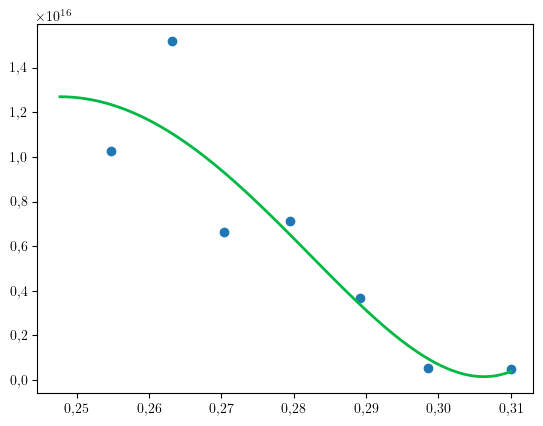

In [31]:
#Prueba 3
#Función de densidad - Transport analysis of stellarator reactors
import scipy.optimize as opt
from scipy.interpolate import UnivariateSpline
r_exp5 = np.array([0.2548, 0.2632, 0.2703, 0.2795, 0.2891, 0.2985, 0.3100]) #original
def n_2(x, n0, P, exp1, gamma):
    return n0*((1-P)*(1-((x-0.2477)/0.3)**2)**exp1 +  P*(1-gamma*((x-0.2477)/0.30)**2)**0.5)

p0_n2 = [3.5e+16, 0.33, 4, 0.011]
r_plot1212 = np.linspace(0.2477, 0.31, num=98) #Mitad, num = 98 por el numero de superficies
ParametrosOptimizados_ne3, pcov_ne2 = opt.curve_fit(n_2, r_exp5, ne13, p0_n2) 
plt.plot(r_exp5, ne13, "o")
plt.plot(r_plot1212, n_2(r_plot1212, *ParametrosOptimizados_ne3), linewidth=2, color = '#00B945')
print(ParametrosOptimizados_ne3)
#print(n_2(r_plot1212, *ParametrosOptimizados_ne3))
#Sigma - mínimos cuadrados ponderados 
ne2_std = np.array([np.std(n_e_20_Bst)/np.sqrt(3), np.std(n_e_30_B)/np.sqrt(3), np.std(n_e_40_B)/np.sqrt(3), 
                   np.std(n_e_50_B)/np.sqrt(3), np.std(n_e_60_B)/np.sqrt(3), np.std(n_e_70_B)/np.sqrt(3), 
                   np.std(n_e_80_B)/np.sqrt(3)])
residuos_ne3 = ne13 - n_2(r_exp5, *ParametrosOptimizados_ne3)
ss_res_ne3 = np.sum(residuos_ne3**2) #residual sum of squares
ss_tot_ne3 = np.sum((ne13-np.mean(ne13))**2) #total sum of squares
r_2_ne2 = 1 - (ss_res_ne3 / ss_tot_ne3)

#Hipótesis de correlación
#https://www.w3schools.com/python/scipy/scipy_statistical_significance_tests.php
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import kstest

r_pear, p_value = pearsonr(r_exp5, ne13)
p_value_no_lineal = res = ttest_ind(r_exp5, ne13).pvalue

print("el valor de p (pearson) es", p_value)
print("el valor de p es", p_value_no_lineal)
print("el valor de r_pear es", r_pear)
print(r_2_ne2)

In [38]:
#Radio mayor (m)
Radio_mayor = 0.2477 
#Valores en un barrido determinado (tercer y cuarto)
T_e_2_B = np.array([T_e_2[3], T_e_2[8], T_e_2[13]])
T_e_3_B = np.array([T_e_3[3], T_e_3[8], T_e_3[13]])
T_e_4_B = np.array([T_e_4[3], T_e_4[8], T_e_4[13]])
T_e_5_B = np.array([T_e_5[1], T_e_5[6], T_e_5[11]])
T_e_6_B = np.array([T_e_6[3], T_e_6[8], T_e_6[13]])
T_e_7_B = np.array([T_e_7[3], T_e_7[8], T_e_7[13]])
T_e_8_B = np.array([T_e_8[3], T_e_8[7], T_e_8[12]])


#Valores en un barrido determinado (tercer y cuarto)
n_e_2_Bst = np.array([n_e_2[3], n_e_2[8], n_e_2[13]])
n_e_2_B = np.array([n_e_2[12]])
#n_e_3_B = np.array([n_e_3[3], n_e_3[8], n_e_3[13]])
n_e_3_B = np.array([n_e_3[7], n_e_3[12]])
#n_e_4_B = np.array([n_e_4[3], n_e_4[8], n_e_4[13]])
n_e_4_B = np.array([n_e_4[3], n_e_4[13]]) #Revisar
#n_e_5_B = np.array([n_e_5[3], n_e_5[8], n_e_5[13]])
n_e_5_B = np.array([n_e_5[7], n_e_5[12]])
n_e_6_B = np.array([n_e_6[3], n_e_6[8], n_e_6[13]])
n_e_7_B = np.array([n_e_7[3], n_e_7[7], n_e_7[12]])
n_e_8_B = np.array([n_e_8[3], n_e_8[7], n_e_8[12]])
print(n_e_2 )

#Matriz final - valores promedio para cada barrido
r_exp = np.array([0.2477, 0.2548, 0.2632, 0.2703, 0.2795, 0.2891, 0.2985, 0.3100]) #original
r_exp = np.array([0.2548, 0.2632, 0.2703, 0.2795, 0.2891, 0.2985, 0.3100]) #original

Te = np.array([np.mean(T_e_2_B), np.mean(T_e_3_B), np.mean(T_e_4_B),
               np.mean(T_e_5_B), np.mean(T_e_6_B), np.mean(T_e_7_B), np.mean(T_e_8_B)] ) #original
ne = np.array([np.mean(n_e_2_B), np.mean(n_e_3_B), np.mean(n_e_4_B),
               np.mean(n_e_5_B), np.mean(n_e_6_B), np.mean(n_e_7_B), np.mean(n_e_8_B)] ) #original


#Se importa la función para optimizar de scipy
import scipy.optimize as opt

# Función para ajustar datos de densidad y temperatura.
def gaussiana(x, amplitud, desvest, exponente):
    return amplitud * np.exp(-( (x-0.2477) / desvest )**exponente)

#Función de densidad - Transport analysis of stellarator reactors
def n_2(x, n0):
    return n0*np.power((1-x),2) 

#Sigma - mínimos cuadrados ponderados 
Te_std = np.array([np.std(T_e_2_B)/np.sqrt(3), np.std(T_e_3_B)/np.sqrt(3), np.std(T_e_4_B)/np.sqrt(3), 
                   np.std(T_e_5_B)/np.sqrt(3), np.std(T_e_6_B)/np.sqrt(3), np.std(T_e_7_B)/np.sqrt(3), 
                   np.std(T_e_8_B)/np.sqrt(3)])
ne_std = np.array([np.std(n_e_2_Bst)/np.sqrt(3), np.std(n_e_3_B)/np.sqrt(3), np.std(n_e_4_B)/np.sqrt(3), 
                   np.std(n_e_5_B)/np.sqrt(3), np.std(n_e_6_B)/np.sqrt(3), np.std(n_e_7_B)/np.sqrt(3), 
                   np.std(n_e_8_B)/np.sqrt(3)])


#Se ajustan los datos optimizados - MODIFICAR
p0_T = [T_e_1[3], 1, 2]
p0_n = [n_e_2[9], 1.91583770e-02, 2.15383099e+00] #original
#p0_n = [n_e_2[6]] #original


#Parámetros optimizados para T_e y n_e
ParametrosOptimizados_ne, pcov_ne = opt.curve_fit(gaussiana, r_exp, ne, p0_n)
ParametrosOptimizados_Te, pcov_Te = opt.curve_fit(gaussiana, r_exp, Te, p0_T)
#ParametrosOptimizados_ne2, pcov_ne2 = opt.curve_fit(n_2, r_exp, ne, p0_n)


#Cálculo del coeficiente de determinación
residuos = Te - gaussiana(r_exp, *ParametrosOptimizados_Te)
ss_res = np.sum(residuos**2) #residual sum of squares
ss_tot = np.sum((Te-np.mean(Te))**2) #total sum of squares
r_2_Te = 1 - (ss_res / ss_tot)
print(r_2_Te)

residuos_ne = ne - gaussiana(r_exp, *ParametrosOptimizados_ne)
ss_res_ne = np.sum(residuos_ne**2) #residual sum of squares
ss_tot_ne = np.sum((ne-np.mean(ne))**2) #total sum of squares
r_2_ne = 1 - (ss_res_ne / ss_tot_ne)
print(r_2_ne)

print(np.sqrt(np.diag(pcov_ne)))
print(np.sqrt(np.diag(pcov_Te)))

#Perfil de presión
#TE = gaussiana(r_plot, *ParametrosOptimizados_Te)
#NE = gaussiana(r_plot, *ParametrosOptimizados_ne)
#np.savetxt('te_ne_perfil_presion.txt', np.c_[r_plot, TE, NE],  header='r (m), te (ev), ne(m^3)')

#print(TE)

#Exportar datos de densidad
#n_e_inter = gaussiana(r_plot, *ParametrosOptimizados)
#np.savetxt('densidad.txt', n_e_inter, delimiter=',')   # X is an array

#Hipótesis de correlación
#https://www.w3schools.com/python/scipy/scipy_statistical_significance_tests.php
#https://www.scribbr.com/statistics/p-value/

from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind


r_pear_Te, p_value_Te = pearsonr(r_exp, Te)
p_value_no_lineal_Te = ttest_ind(r_exp, Te).pvalue

print("el valor de p_Te (pearson) es", p_value_Te)
print("el valor de p_Te es", p_value_no_lineal_Te)
print("el valor de r_pear_Te es", r_pear_Te)


r_pear_ne, p_value_ne = pearsonr(r_exp, ne)
p_value_no_lineal_ne = ttest_ind(r_exp, ne).pvalue

print("el valor de p_ne (pearson) es", p_value_ne)
print("el valor de p_ne es", p_value_no_lineal_ne)
print("el valor de r_pear_ne es", r_pear_Te)


print(ParametrosOptimizados_Te)
print(ParametrosOptimizados_ne)


[6.21842493e+15 1.02381484e+16 9.71716424e+15 5.42682786e+15
 5.39312896e+15 4.96888572e+15 6.61504518e+15 6.87175188e+15
 9.52096419e+15 8.60289372e+15 3.02214939e+15 7.38530358e+15
 1.02577632e+16 1.03965168e+16 9.40371025e+15]
0.9693436723177712
0.8289067306545486
[2.55523579e+15 6.30163561e-03 2.02400847e+00]
[1.44521431 0.00423598 0.36581474]
el valor de p_Te (pearson) es 0.00011360882196934118
el valor de p_Te es 9.317855216878439e-05
el valor de r_pear_Te es -0.9795500101568388
el valor de p_ne (pearson) es 0.00787825707109931
el valor de p_ne es 0.008762839346629348
el valor de r_pear_ne es -0.9795500101568388
[15.06028366  0.04832166  1.42605326]
[1.21258990e+16 3.75060842e-02 2.88615894e+00]


/tmp/ipykernel_79612/445997976.py:42: RuntimeWarning: overflow encountered in power
  return amplitud * np.exp(-( (x-0.2477) / desvest )**exponente)
/tmp/ipykernel_79612/445997976.py:42: RuntimeWarning: invalid value encountered in power
  return amplitud * np.exp(-( (x-0.2477) / desvest )**exponente)
/tmp/ipykernel_79612/445997976.py:100: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


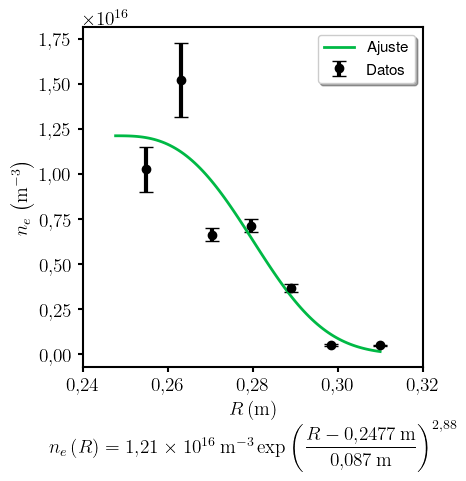

In [68]:
#Graficación
r_plot = np.linspace(0.2477, 0.31, num=98) #Mitad, num = 98 por el numero de superficies

fig = plt.figure(figsize=(30, 15))  # create a figure object 
#ax1 = fig.add_subplot(311)
#ax1.errorbar(r_exp, Te, yerr=Te_std,  fmt ='o', linewidth=1, color= 'black', capsize=5)
#ax1.plot(r_exp, Te, 'o')
#ax1.plot(np.arange(0.2498,0.31+0.001,0.001), fitt)
#ax1.plot(r_plot, gaussiana(r_plot, *ParametrosOptimizados_Te), linewidth=2, color ='#FF9500')
#ax1.set_ylabel(r'$T_e$ $\left( \si{\electronvolt} \right)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
#ax1.set_xlabel(r'$R \left( \si{\metre} \right)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
#ax1.tick_params(axis='both', labelsize=14, width=1.5) 
#ax1.legend((r'Ajuste', r'Datos'), loc='upper right', fontsize=11,  ncol=1, fancybox=True, shadow=True)
#ax1.legend((r'Fit', r'Data'), loc='upper right', fontsize=11,  ncol=1, fancybox=True, shadow=True)

#ax2 = fig.add_subplot(312)
ax2 = fig.add_subplot(311)
ax2.errorbar(r_exp, ne, yerr=ne_std,  fmt ='o', linewidth=1,  color='black',ecolor='black', elinewidth=3, capsize=5)
#ax2.plot(r_exp,ne, 'o')
#ax2.plot(np.arange(0.2498,0.31+0.001,0.001), fit)
ax2.plot(r_plot, gaussiana(r_plot, *ParametrosOptimizados_ne), linewidth=2, color = '#00B945')
#ax2.plot(r_plot, n_2(r_plot, *ParametrosOptimizados_ne), linewidth=2, color = '#00B945')
ax2.set_ylabel(r'$n_{e}$ $\left( \si{\metre^{-3}} \right)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
#ax2.set_xlabel(r'R $\left( \si{\metre} \right)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
ax2.tick_params(axis='both', labelsize=14, width=1.5) 
ax2.legend((r'Ajuste', r'Datos'), loc='upper right', fontsize=11,  ncol=1, fancybox=True, shadow=True)
#ax2.legend((r'Fit', r'Data'), loc='upper right', fontsize=11,  ncol=1, fancybox=True, shadow=True)
ax2.yaxis.get_offset_text().set_fontsize(14)

#ax3 = fig.add_subplot(313)
#ax3.errorbar(r_exp, ne, yerr=ne2_std,  fmt ='o', linewidth=1,  color='black',ecolor='black', elinewidth=3, capsize=5)
#ax3.plot(r_plot1212, n_2(r_plot1212, *ParametrosOptimizados_ne3), linewidth=2, color = '#845B97')
#ax3.set_ylabel(r'$n_{e}$ $\left( \si{\metre^{-3}} \right)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
#ax3.set_xlabel(r'$R \left( \si{\metre} \right)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
#ax3.tick_params(axis='both', labelsize=14, width=1.5) 
#ax3.legend((r'Ajuste', r'Datos'), loc='upper right', fontsize=11,  ncol=1, fancybox=True, shadow=True)
ax2.set_xlabel(r'$R \left( \si{\metre} \right)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
#ax1.set_xlabel(r' $ R \left( \si{\metre} \right)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})


#plt.setp(ax1.spines.values(), linewidth=1.5)
plt.setp(ax2.spines.values(), linewidth=1.5)
#plt.setp(ax3.spines.values(), linewidth=1.5)
#ax1.text(0.6,0.9, r"$\text{(a)}$", fontsize =14, fontdict=None, transform=ax1.transAxes ) #Etiquetar gráfica
#ax2.text(0.6,0.9, r'$\text{(b)}$', fontsize =14, fontdict=None, transform=ax2.transAxes) #Etiquetar gráfica fontdict = none para que intrpete latex
#ax1.text(0.0,-0.27, r'$T_{e} \left( R \right) = \SI{15.1}{\electronvolt} \exp \left( \dfrac{R - \SI{0.2477}{\metre}}{\SI{0.048}{\metre}} \right)^{\num{1.40}}$', fontsize =14, fontdict=None, transform=ax1.transAxes) #Etiquetar gráfica fontdict = none para que intrpete latex
ax2.text(-0.1,-0.25, r'$n_{e} \left( R \right) = \SI{1.21e16}{\meter^{-3}} \exp \left( \dfrac{R - \SI{0.2477}{\metre}}{\SI{0.087}{\metre}} \right)^{\num{2.88}}$', fontsize =14, fontdict=None, transform=ax2.transAxes) #Etiquetar gráfica fontdict = none para que intrpete latex
#ax1.set_xlim(0.24, 0.31+0.01)
ax2.set_xlim(0.24, 0.31+0.01)
#ax3.text(0.6,0.9, r'$\text{(c)}$', fontsize =14, fontdict=None, transform=ax3.transAxes) #Etiquetar gráfica fontdict = none para que i

# Show the graph
#plt.legend()
#ax1.set_aspect(1 / ax1.get_data_ratio())
ax2.set_aspect(1 / ax2.get_data_ratio())
#ax3.set_aspect(1 / ax3.get_data_ratio())
ax2.yaxis.get_offset_text().set_fontsize(14) #tamaño de letra del x10^{}
#ax3.yaxis.get_offset_text().set_fontsize(14) #tamaño de letra del x10^{}

if idioma == 'español':
        plt.savefig('perfil_ne.png', dpi=300, bbox_inches='tight')
        #plt.savefig('perfil_Te.png', dpi=300, bbox_inches='tight')
        #plt.savefig('perfiles.png', dpi=300, bbox_inches='tight')
if idioma == 'ingles' :
        plt.savefig('perfil_ne.eps', format='eps', dpi=300, bbox_inches='tight') #paper IOP
        #plt.savefig('perfil_Te.eps', format='eps', dpi=300, bbox_inches='tight') #paper IOP


#plt.savefig('perfiles.png', dpi=300, bbox_inches='tight') 

plt.show() 

In [ ]:
#ajuste 1 - cero grados toroidal

r_plot = np.linspace(0.2477, 0.31, num=101) #Completo
parametros_Te = np.array([15.06028366,  0.04832166,  1.42605326])#original
parametros_ne = np.array([1.21258990e+16, 0.1*0.087, 2.88615894e+00])

#parametros_ne = np.array([1.21258990e+16, 3.75060842e-02, 2.88615894e+00])#original
#parametros_ne = np.array([5.96328227e+15, 2.87533799e-02, 2.59908430e+00])

#Grafico temperatura
y_T = parametros_Te[0]*np.exp( -((r_plot-0.2477)/(parametros_Te[1]))**parametros_ne[2])


#Grafico densidad
y_n = parametros_ne[0]*np.exp( -((r_plot-0.2477)/(parametros_ne[1]))**parametros_ne[2])



#Interpolación
from scipy import interpolate #interpolación 
f_yT = interpolate.interp1d(r_plot, y_T, kind = 'linear') #funcion de densidad
rr = np.linspace(0.2477, 0.31, num=101)
yt= f_yT(rr)
#print(f_yT(0.303797))

Radio_mayor = 0.2477
r_final = 2*Radio_mayor - r_plot

#se concatenan los datos
r = np.concatenate((np.flipud(r_final[1:]),r_plot))
y_FTe = np.concatenate((np.flipud(y_T[1:]), y_T))
y_Fne = np.concatenate((np.flipud(y_n[1:]), y_n))
#print(y_FTe)

#Se utilizan en el input de IPF-FDMC
np.savetxt('densidad_28ghz.txt', y_n, delimiter=',')   # X is an array
#np.savetxt('temperatura.txt', y_T, delimiter=',')   # X is an array

#Uso del coeficiente ión - electrón
#np.savetxt('Densidad_col_ie.txt', y_Fne, delimiter=',')   # X is an array
#np.savetxt('Temperatura_col_ie.txt', y_FTe, delimiter=',')   # X is an array

#Uso para el perfil de presión en VMEC
#C = np.c_[r_plot, y_T, y_n]
#np.savetxt('te_ne_perfil_presion.txt',  C , header='r (m), Te (ev), n(m^-3)', 
           #delimiter=' ', fmt='%f') #quitar notación científica


plt.plot(r, y_Fne)
plt.show()

In [ ]:
#Ajuste 2 con prueba 3

r_plot = np.linspace(0.2477, 0.31, num=101) #Completo
parametros_ne = np.array([1.26989121e+16, -2.51098661e+01, 5.99007675e+00, 8.44771333e+00])#original


#Grafico densidad
y_n = parametros_ne[0]*((1-parametros_ne[1])*(1-((r_plot-0.2477)/0.3)**2)**parametros_ne[2] 
                        +  parametros_ne[1]*(1-parametros_ne[3]*((r_plot-0.2477)/0.30)**2)**0.5)

#Interpolación
#from scipy import interpolate #interpolación 
#f_yN = interpolate.interp1d(r_plot, y_n, kind = 'linear') #funcion de densidad
#rr = np.linspace(0.2477, 0.31, num=101)
#yt= f_yN(rr)
#print(f_yN(0.303797))

Radio_mayor = 0.2477
r_final = 2*Radio_mayor - r_plot

#se concatenan los datos
r = np.concatenate((np.flipud(r_final[1:]),r_plot))
y_Fne = np.concatenate((np.flipud(y_n[1:]), y_n))
#print(y_FTe)

#Se utilizan en el input de IPF-FDMC
np.savetxt('densidad_perfil_2.txt', y_n, delimiter=',')   # X is an array
#np.savetxt('temperatura_perfil_2.txt', y_T, delimiter=',')   # X is an array

#Uso del coeficiente ión - electrón
#np.savetxt('Densidad_col_ie.txt', y_Fne, delimiter=',')   # X is an array
#np.savetxt('Temperatura_col_ie.txt', y_FTe, delimiter=',')   # X is an array

#Uso para el perfil de presión en VMEC
#C = np.c_[r_plot, y_T, y_n]
#np.savetxt('te_ne_perfil_presion.txt',  C , header='r (m), Te (ev), n(m^-3)', 
           #delimiter=' ', fmt='%f') #quitar notación científica


plt.plot(r, y_Fne)
plt.show()

In [ ]:
#Se importa la función para optimizar de scipy
import scipy.optimize as opt
from scipy.interpolate import UnivariateSpline
# Polynomial Regression
def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results, p

In [ ]:
#Prueba 1
r_exp5 = np.array([0.2548, 0.2632, 0.2703, 0.2795, 0.2891, 0.2985, 0.3100]) #original
datos_Te, fit_Te = polyfit(r_exp5, Te13, 2)
datos_ne, fit_ne = polyfit(r_exp5, ne13, 3)
print(datos_Te)
print(datos_ne)

spl = UnivariateSpline(r_exp5, ne13,)
spl.set_smoothing_factor(0.5)


#Graficación
r_plot = np.linspace(0.2477, 0.31, num=98) #Mitad, num = 98 por el numero de superficies

fig = plt.figure(figsize=(12, 12))  # create a figure object

ax1 = fig.add_subplot(211)
ax1.plot(r_exp5, Te13, "o" )
ax1.plot(r_plot, fit_Te(r_plot))
ax1.set_ylabel(r'$T_e$ $\left( \si{\electronvolt} \right)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
#ax1.set_xlabel(r'Distancia radial $\left( \si{\metre} \right)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
ax1.tick_params(axis='both', labelsize=14, width=1.5) 
ax1.legend((r'Ajuste', r'Datos'), loc='upper right', fontsize=11,  ncol=1, fancybox=True, shadow=True)

ax2 = fig.add_subplot(212)
ax2.plot(r_exp5, ne13, "o" )
ax2.plot(r_plot, fit_ne(r_plot))
#ax2.plot(r_plot, spl(r_plot))
ax2.set_ylabel(r'$n_{e}$ $\left( \si{\metre^{-3}} \right)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
ax2.set_xlabel(r'R $\left( \si{\metre} \right)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
ax2.tick_params(axis='both', labelsize=14, width=1.5) 
ax2.legend((r'Ajuste', r'Datos'), loc='upper right', fontsize=11,  ncol=1, fancybox=True, shadow=True)


plt.setp(ax1.spines.values(), linewidth=1.5)
plt.setp(ax2.spines.values(), linewidth=1.5)
ax1.text(0.7,0.9, r"$\text{(a)}$", fontsize =14, fontdict=None, transform=ax1.transAxes ) #Etiquetar gráfica
ax2.text(0.7,0.9, r'$\text{(b)}$', fontsize =14, fontdict=None, transform=ax2.transAxes) #Etiquetar gráfica fontdict = none para que intrpete latex


# Show the graph
#plt.legend()
ax1.set_aspect(1 / ax1.get_data_ratio())
ax2.set_aspect(1 / ax2.get_data_ratio())
ax2.yaxis.get_offset_text().set_fontsize(14) #tamaño de letra del x10^{}

In [ ]:
#Prueba 2
fac_20 = 1
fac_30 = 1
fac_40 = 1
fac_50 = 1
fac_60 = 1
ne2 = np.array([n_e_20*fac_20, n_e_30*fac_30, n_e_40*fac_40, n_e_50*fac_50, n_e_60*fac_60, n_e_70], dtype=object)
ne21 = np.array([n_e_20*fac_20, n_e_30*fac_30, n_e_40*fac_40, n_e_50*fac_50, n_e_60*fac_60, n_e_70])
ne3 = np.array([np.mean(n_e_20), np.mean(n_e_30)*fac_30, 
                np.mean(n_e_40)*fac_40, np.mean(n_e_50)*fac_50, np.mean(n_e_60), 
                np.mean(n_e_70)])
r_exp = np.array([0.2548, 0.2632, 0.2703, 0.2795, 0.2891, 0.2985]) #original
ne21 = np.hstack(ne21)
#print(ne2)
ne2 = np.hstack(ne2)
r_final = np.array([r_exp[0]*np.ones(n_e_20.shape[0]), 
                    r_exp[1]*np.ones(n_e_30.shape[0]), r_exp[2]*np.ones(n_e_40.shape[0]),  
                    r_exp[3]*np.ones(n_e_50.shape[0]), r_exp[4]*np.ones(n_e_60.shape[0]),
                    r_exp[5]*np.ones(n_e_70.shape[0])], dtype=object)
r_final1 = np.array([r_exp[0]*np.ones(n_e_20.shape[0]), 
                    r_exp[1]*np.ones(n_e_30.shape[0]), r_exp[2]*np.ones(n_e_40.shape[0]),  
                    r_exp[3]*np.ones(n_e_50.shape[0]), r_exp[4]*np.ones(n_e_60.shape[0]),
                    r_exp[5]*np.ones(n_e_70.shape[0])])
r_final = np.hstack(r_final)
r_final1 = np.hstack(r_final1)
_, fit_ne_todos = polyfit(r_final1, ne21, 4)
plt.plot(r_final, ne2, "o")
print(_)
plt.plot(r_exp,ne3, "x")
#plt.plot(r_final, 1.2e16*(1-r_final*r_final))
plt.plot(r_final, fit_ne_todos(r_final))